In [27]:
gen = "QGSM"

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
true = True
false = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_NAME = f'{gen}_Big_InvTime'
if gen == 'QGSM' or gen == 'EPOS':
    INPUT_FILE = f'data/modeled/PD173_{gen}_Big_InvTime'
else:
    raise Exception('Wrong generator format!')

doSaveFigures = True
doSaveModel = False

isTimeOfFlight = True
isSimpleTime = False
isBigRings = True

number_of_groups = 2                # Количество интервалов на которые делятся прицельные параметры
number_of_epoches_lin = 5           # Количество эпох в обучении полносвязной нейросети
number_of_epoches_conv = 50         # Количество эпох в обучении сверточной нейросети
training_set_part = 0.8             # Часть от 0 до 1 выделяемая на тренировочный набор
batch_size = 400                    # Размер батча

# CHOSE THRESHOLD
threshold = 5

if threshold == 1:
    loss_weights = torch.tensor([1.0, 0.005]).to(device)                                  # for 1 fm threshold
elif threshold == 5:
    loss_weights = torch.tensor([1.0, 0.1466]).to(device)                                   # for 5 fm threshold
else:
    loss_weights = torch.tensor([1.0, 0.33]).to(device)                                   # for 7 fm threshold

# Normalize event features
if isTimeOfFlight:
    if isSimpleTime:
        if isBigRings:
            FEATURES_AMPLITUDES = [20, 352, 2]
        else:
            FEATURES_AMPLITUDES = [20, 32, 6]
    else:
        if isBigRings:
            FEATURES_AMPLITUDES = [50, 100, 2]
        else:
            FEATURES_AMPLITUDES = [200, 32, 6]
else:
    if isBigRings:
        FEATURES_AMPLITUDES = [0.015, 100]
    else:
        FEATURES_AMPLITUDES = [0.015, 50]

avg_pion_times = [3.345, 5.675, 8.355]
input_data = []
times_of_first_particles = []

imp_parameters = []

with open(f'{INPUT_FILE}.dat', 'r') as inpf:
    l = inpf.readline()
    s = l.strip().split()

    # Чтение максимального количества данных в строке и количества строк для одного события
    if isTimeOfFlight:
        maximum_hits = int(s[2])                                                                                                      #
        n_lines = int(s[4])                                                                                                           #

    if isTimeOfFlight:
        number_of_features = n_lines * maximum_hits
    else:
        number_of_features = 2

    # number_of_features = 1 #len(s[8:])
    print("Number of features: {}".format(number_of_features))
    print(l)
    max_b = 0.0
    max_coord = 0.0
    max_phi = 0.0
    norm_labels = True

    # l = inpf.readline()

    amount = 0
    for line in inpf:
        features = []
        s = line.strip().split()
        b = float(s[0])
        coord = float(s[1])
        phi_b = float(s[2])

        if norm_labels:
            max_b = max(b, max_b)
            max_phi = max(abs(phi_b), max_phi)
            max_coord = max(abs(coord), max_coord)

        imp_parameters.append(b)

        n = 0
        # investigated_det = 1
        timeFeatures = []
        cellFeatures = []
        detFeatures = []
        if isTimeOfFlight:
            for particlePlace in range(maximum_hits):
                timeFeatures.append(float(s[3 + particlePlace + 0 * maximum_hits]) / FEATURES_AMPLITUDES[0])
                cellFeatures.append(float(s[3 + particlePlace + 1 * maximum_hits]) / FEATURES_AMPLITUDES[1])
                detFeatures.append(float(s[3 + particlePlace + 2 * maximum_hits]) / FEATURES_AMPLITUDES[2])
            features = timeFeatures + cellFeatures + detFeatures
        else:
            features.append(float(s[3]) / FEATURES_AMPLITUDES[0])                                                                            # Reading n features in given angles
            features.append(float(s[4]) / FEATURES_AMPLITUDES[1])


        if s[3] != 'nan' and s[3]!= '0':
            times_of_first_particles.append(float(s[3]))
            input_data.append([b, coord, phi_b, features])
            amount += 1
        # input_data.append([b, coord, features])



maximum_values = [max_b, max_coord, max_phi]
print(input_data[0:5])
print(len(input_data))

cuda:0
Number of features: 450
Maximum hits: 150 Lines: 3 

[[0.158, 0.0, 0.0, [-0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, 1.0, 1.0, 0.28571428, 0.28571428, 0.28571428, 0.28571428, 0.28571428, 0.28571428, 0.16666666, 0.16666666, 0.16666666, 0.16666666, 0.09090909, 0.09090909, 0.07407407199999999, 0.0625, 0.0625, 0.0625, 0.0625, 0.054054055999999996, 0.047619048, 0.047619048, 0.038461538, 0.0186915886, 0.012345678799999999, 0.00921659, 0.0049140048, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [28]:
# Создание класса для набора данных с двумя функциями
class DatasetNN(torch.utils.data.Dataset):
    def __init__(self, labels, features):           # В этом методе создаются две переменные для характеристик и для меток
        self.labels = labels
        self.features = features

    def __len__(self):                       # Эта функция должна возвращать размер набора данных
        return self.labels.shape[0]

    def __getitem__(self, idx):              # Эта функция возвращает один (или несколько, зависит от размерности переменной idx) из примеров данных с индексом idx
        if torch.is_tensor(idx):             # Если набор индексов задан как тензор, то приведение его к виду списка
            idx = idx.tolist()

        label = self.labels[idx]

        feature = self.features[idx]

        sample = {'label': label, 'feature': feature}   # Возвращает пример (набор примеров) в виде словаря (пара метка-характеристика)

        return sample
    
def get_correct_predictions(preds: torch.Tensor, values: torch.Tensor) -> int:
    return preds.argmax(dim=1).eq(values).sum().item()

def encode_binary(labels_arr: np.ndarray, border: float) -> np.ndarray:
    result_arr = np.zeros_like(labels_arr)
    for ind in range(len(labels_arr)):
        if labels_arr[ind] > border:
            result_arr[ind] = 1
    return result_arr


np.random.shuffle(input_data)
input_sorted = sorted(input_data, key=lambda x: (x[0]))
    
features = np.zeros((len(input_data), number_of_features))
labels = np.zeros((len(input_data), 1))
coordinates = np.zeros((len(input_data), 1))
incr = 0
for elem in input_data:
    labels[incr] = np.array(elem[0])
    coordinates[incr] = np.array(elem[1])
    features[incr] = np.array(elem[3])
    incr += 1


# Divide into test and training sets
size_of_training_set = int(features.shape[0] * training_set_part)
size_of_test_set = features.shape[0] - size_of_training_set

# Divide labes into test and training sets
print("Были прицельные параметры: \n {}".format(labels[:6]))
labels_encoded_binary = encode_binary(labels, border=threshold)
print("Закодированы в интервалы: \n {}".format(labels_encoded_binary[:6]))
train_labels = torch.flatten(torch.tensor(labels_encoded_binary[:size_of_training_set])).to(device)
test_labels = (torch.flatten(torch.tensor(labels_encoded_binary[size_of_training_set:]))).type(torch.LongTensor).to(device)
big_test_labels = np.count_nonzero(test_labels.to(device='cpu'))
amount_of_test_labels =  [size_of_test_set - big_test_labels, big_test_labels]
print(amount_of_test_labels)


train_features = torch.tensor(features[:size_of_training_set], dtype=torch.float32).to(device)
test_features = torch.tensor(features[size_of_training_set:], dtype=torch.float32).to(device)


print('Train features shape: {}'.format(train_features.shape))
print('Test features shape: {}'.format(test_features.shape))

print('Train labels shape: {}'.format(train_labels.shape))
print('Test labels shape: {}'.format(test_labels.shape))

Были прицельные параметры: 
 [[3.812]
 [7.942]
 [9.062]
 [2.311]
 [7.815]
 [9.421]]
Закодированы в интервалы: 
 [[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]
[94, 682]
Train features shape: torch.Size([3103, 450])
Test features shape: torch.Size([776, 450])
Train labels shape: torch.Size([3103])
Test labels shape: torch.Size([776])


In [29]:
# Объявление класса сверточной сети
class NetworkConv(nn.Module):
    def __init__(self):
        super(NetworkConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(n_lines, 6), stride=(1, 2))
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(n_lines, 40), stride=(1, 40))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)


        # self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        self.lin1 = nn.Linear(in_features=self.conv1.out_channels*(int((maximum_hits)/2) - 2), out_features=128)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)

        self.lin2 = nn.Linear(in_features=self.lin1.out_features, out_features=64)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)

        self.lin3 = nn.Linear(in_features=self.lin2.out_features, out_features=32)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)

        # self.lin4 = nn.Linear(in_features=self.lin3.out_features, out_features=8)
        # nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)

        self.out = nn.Linear(in_features=self.lin3.out_features, out_features=number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)

    def forward(self, t):
        t = torch.reshape(t, (-1, 1, n_lines, maximum_hits))
        t = F.leaky_relu(self.conv1(t))
        # t = F.relu(self.conv2(t))
        # t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = F.leaky_relu(self.lin1(t.reshape(-1, self.conv1.out_channels*(int((maximum_hits)/2) - 2))))
        # t = F.relu(self.lin1(t.reshape(-1, self.conv1.out_channels*(int((maximum_hits)/40)))))
        t = F.leaky_relu(self.lin2(t))
        t = F.leaky_relu(self.lin3(t))
        # t = F.relu(self.lin4(t))

        t = F.softmax(self.out(t), dim=1)
        return t

class NetworkDense(nn.Module):
    def __init__(self):
        super(NetworkDense, self).__init__()
        if isTimeOfFlight:
            self.lin1 = nn.Linear(in_features = number_of_features, out_features = 256)             # Time
        else:
            self.lin1 = nn.Linear(in_features = number_of_features, out_features = 4)               # Stat
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        if isTimeOfFlight:
            self.lin2 = nn.Linear(in_features = self.lin1.out_features, out_features = 64)          # Time
        else:
            self.lin2 = nn.Linear(in_features = self.lin1.out_features, out_features = 8)           # Stat
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)
        
        self.lin3 = nn.Linear(in_features = self.lin2.out_features, out_features = 16)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        self.lin4 = nn.Linear(in_features = self.lin3.out_features, out_features = 4)
        nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)
        
        # self.lin5 = nn.Linear(in_features = self.lin4.out_features, out_features = 8)
        # nn.init.normal_(self.lin5.weight, mean=0.0, std=0.2)
        
        # self.lin6 = nn.Linear(in_features = self.lin5.out_features, out_features = 4)
        # nn.init.normal_(self.lin6.weight, mean=0.0, std=0.2)
        
        self.out = nn.Linear(in_features = self.lin4.out_features, out_features = number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        # print(self.lin1.weight[:4, :8])
        # print(self.lin2.weight[:4, :8])
        # print(self.lin3.weight[:4, :8])
        # print(self.out.weight)
        
    def forward(self, t):
        t = t
        t = F.leaky_relu(self.lin1(t))
        t = F.leaky_relu(self.lin2(t))
        t = F.leaky_relu(self.lin3(t))
        t = self.lin4(t)
        # t = F.relu(self.lin5(t))
        # t = F.relu(self.lin6(t))
        t = F.softmax(self.out(t), dim=1)
        return t


In [30]:
# Сверточная сеть - только для времяпролетных характеристик
# net = NetworkConv().to(device)
# Полносвязная сеть
net = NetworkDense().to(device)

# В этом блоке - сам процесс обучения
trDS = DatasetNN(train_labels, train_features)
teDS = DatasetNN(test_labels, test_features)
trDL = torch.utils.data.DataLoader(trDS, batch_size=batch_size, shuffle=True)
teDL = torch.utils.data.DataLoader(trDS, batch_size=len(teDS))



print(net)
optimizer_c = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)

# Here define weights for loss contribution of segments
# loss_weights_c = torch.ones(number_of_groups)
# loss_weights_c = torch.tensor([1.0, 0.125]).to(device)
# print(loss_weights_c)
total_loss_c = []
total_accuracy_c = []
total_val_loss_c = []
total_val_accuracy_c = []

# Learning process
for epoch in range(number_of_epoches_conv):
    total_correct = 0
    t_loss = 0.0
    for batch in trDL:
        batch_labels = batch['label'].type(torch.LongTensor).to(device)
        batch_features = batch['feature'].to(device)

        predicted = net(batch_features)
        loss = F.cross_entropy(predicted, batch_labels, loss_weights)
        optimizer_c.zero_grad()
        loss.backward()
        optimizer_c.step()
        t_loss += (loss.item() * batch_size / len(trDS))
        total_correct += get_correct_predictions(predicted, batch_labels)

    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
    .format(epoch, t_loss, total_correct, total_correct*100/train_features.shape[0]))

    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss_c.append(t_loss)
        total_accuracy_c.append(total_correct*100/train_features.shape[0])

        test_preds = net(test_features)
        total_val_loss_c.append(F.cross_entropy(test_preds, test_labels, loss_weights).item())
        total_val_accuracy_c.append(get_correct_predictions(test_preds, test_labels)*100/test_features.shape[0])



NetworkDense(
  (lin1): Linear(in_features=450, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=2, bias=True)
)
Epoch:    0 |---> loss is 0.7187798374, total correct predictions:  2698, its 86.948%
Epoch:    1 |---> loss is 0.7182659889, total correct predictions:  2698, its 86.948%
Epoch:    2 |---> loss is 0.7165228594, total correct predictions:  2698, its 86.948%
Epoch:    3 |---> loss is 0.7072357451, total correct predictions:  2698, its 86.948%
Epoch:    4 |---> loss is 0.6478934913, total correct predictions:  2781, its 89.623%
Epoch:    5 |---> loss is 0.5113885167, total correct predictions:  2402, its 77.409%
Epoch:    6 |---> loss is 0.4420930556, total correct predictions:  2655, its 85.562%
Epoch:    7 |---> loss is 0.3980547852, total correct predictions:  2887, its 

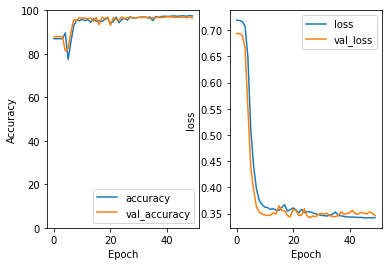

749
Test accuracy is 96.52%
tensor([[ 91.,   3.],
        [ 24., 658.]])
tensor([[ 91.,   3.],
        [ 24., 658.]])
tensor([[0.9681, 0.0319],
        [0.0352, 0.9648]])


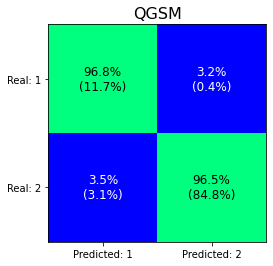

Efficiency    Accuracy     Recall     Precision       F2
QGSM_Big_InvTime     96.52   0.968    0.791     0.927


In [31]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy_c, label='accuracy')
    plt.plot(total_val_accuracy_c, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='lower right')

    plt.subplot(1,2,2)
    plt.plot(total_loss_c, label='loss')
    plt.plot(total_val_loss_c, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')

    if doSaveFigures:
        plt.savefig(f'{IMAGE_NAME}_LearningPlotBinary', dpi=300)
    plt.show()

    test_predictions_c = net(test_features)
    test_correct_predictions_c = get_correct_predictions(test_predictions_c, test_labels)
    print(test_correct_predictions_c)
    test_accuracy_c = test_correct_predictions_c * 100 /test_features.shape[0]
    print("Test accuracy is {:2.2f}%" .format(test_accuracy_c))


    # Creating of confusion matrix
    stacked_c = torch.stack((test_labels, test_predictions_c.argmax(dim=1)), dim=1)
    confusion_matrix_c = torch.zeros((number_of_groups, number_of_groups), dtype=torch.float)
    # horizontal axis - predicted, vertical - true
    for row in stacked_c:
        confusion_matrix_c[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    print(confusion_matrix_c)
    confusion_matrix_c_normed = torch.clone(confusion_matrix_c)

    for i in range(confusion_matrix_c.shape[0]):
        norm = confusion_matrix_c[i][0].item() + confusion_matrix_c[i][1].item()
        confusion_matrix_c_normed[i] /=   norm
    print(confusion_matrix_c)
    print(confusion_matrix_c_normed)

    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix_c_normed, cmap='winter')

    ax.set_xticks(np.arange(confusion_matrix_c.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix_c.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix_c.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(confusion_matrix_c.shape[0]):
        for j in range(confusion_matrix_c.shape[1]):
            cell_label = str(round(confusion_matrix_c_normed[i][j].item()*100, 1)) + '%\n(' + str(round(confusion_matrix_c[i][j].item()*100/test_features.shape[0], 1)) + '%)'
            # text = ax.text(j, i, str(round(confusion_matrix_c[i][j].item()*100/test_features.shape[0],2)) + '%', ha="center", va="center", size=12)
            # text = ax.text(j, i, cell_label, ha="center", va="center", size=12)
            if i == j:
                text = ax.text(j, i, cell_label, ha="center", va="center", size=12)
            else:
                text = ax.text(j, i, cell_label, ha="center", va="center", size=12, color='white')
    plt.title(f'{gen}', fontsize=16)
    if doSaveFigures:
        plt.savefig((f'{IMAGE_NAME}_ConfusionMatrix').replace(".", "_"), dpi=300, bbox_inches='tight')
    plt.show()

# Write metrics into file
with torch.no_grad():
    def Fmeasure(precision, recall, beta)-> float:
        return (1 + beta**2) * precision * recall / (beta * beta * precision + recall)
    recall = confusion_matrix_c_normed[0][0].item()
    precision = confusion_matrix_c[0][0].item() / (confusion_matrix_c[0][0].item() + confusion_matrix_c[1][0].item())
    f2 = Fmeasure(precision, recall, 2)
    print(f'Efficiency    Accuracy     Recall     Precision       F2')
    print(f'{IMAGE_NAME}     {test_accuracy_c:.2f}   {recall:.3f}    {precision:.3f}     {f2:.3f}')
    with open(f'Binary{gen}.txt', 'a') as bin_results:
        bin_results.write(f'\n{IMAGE_NAME}     {test_accuracy_c:.2f}   {recall:.3f}    {precision:.3f}     {f2:.3f}')